In [564]:
import numpy as np
import pandas as pd
import os
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose 
#from pmdarima import auto_arima                        
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
%matplotlib inline

In [565]:
country_to_predict="Syria"

**ARIMA**


In [566]:
df=pd.read_excel('test_arima.xlsx')
df['Year']=pd.to_datetime(df.Year, format="%Y")
df=df[(df['Country']==country_to_predict)]
df.index.freq = 'YS'
df.head()

,Year,Value,Country
343,1970-01-01,58.814,Syria
344,1971-01-01,59.600,Syria
345,1972-01-01,60.378,Syria
346,1973-01-01,61.137,Syria
347,1974-01-01,61.872,Syria


In [567]:
del df["Country"]

In [568]:
df['Year']=pd.to_datetime(df['Year'], format="%Y")
df=df.set_index(['Year'])
df.head()
df.index.freq = 'YS'

In [569]:
train_df = df[:len(df)-6]
test_df = df[len(df)-6:]

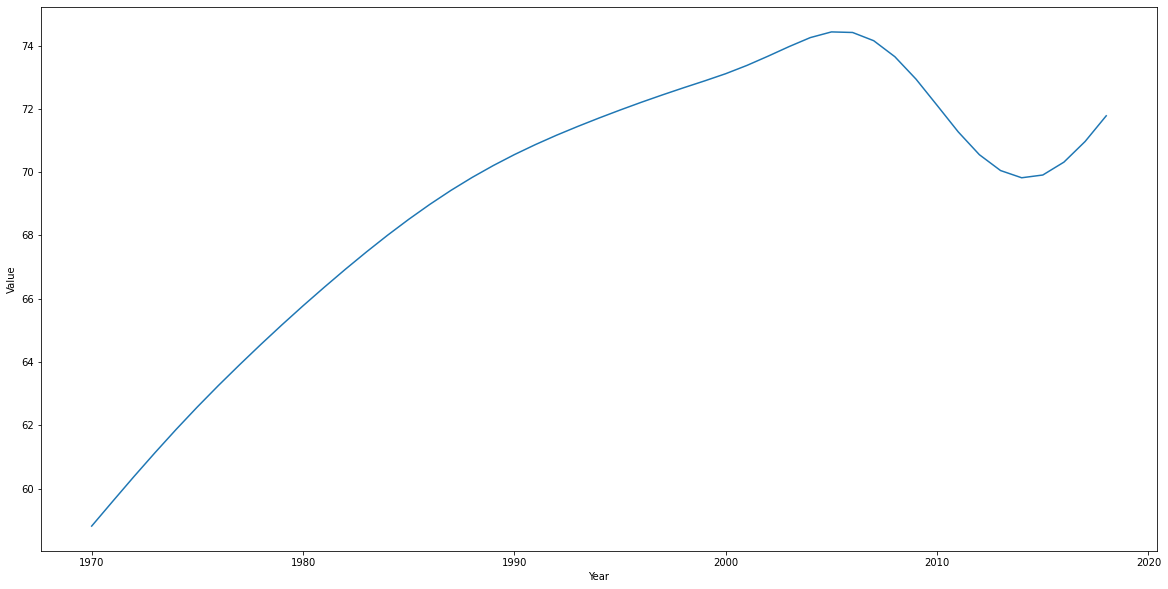

In [570]:
plt.figure(figsize=(20,10))
plt.xlabel("Year")
plt.ylabel("Value")
plt.plot(df)

In [571]:
rolmean=train_df.rolling(window=6).mean()
rolstd=train_df.rolling(window=6).std()
print(rolmean.head(15))
print(rolstd.head(15))

                Value
Year                 
1970-01-01        NaN
1971-01-01        NaN
1972-01-01        NaN
1973-01-01        NaN
1974-01-01        NaN
1975-01-01  60.730000
1976-01-01  61.470667
1977-01-01  62.189667
1978-01-01  62.885333
1979-01-01  63.557833
1980-01-01  64.208167
1981-01-01  64.838167
1982-01-01  65.449833
1983-01-01  66.043667
1984-01-01  66.619167
               Value
Year                
1970-01-01       NaN
1971-01-01       NaN
1972-01-01       NaN
1973-01-01       NaN
1974-01-01       NaN
1975-01-01  1.411416
1976-01-01  1.370305
1977-01-01  1.323435
1978-01-01  1.276884
1979-01-01  1.233759
1980-01-01  1.195204
1981-01-01  1.160437
1982-01-01  1.127717
1983-01-01  1.094853
1984-01-01  1.060950


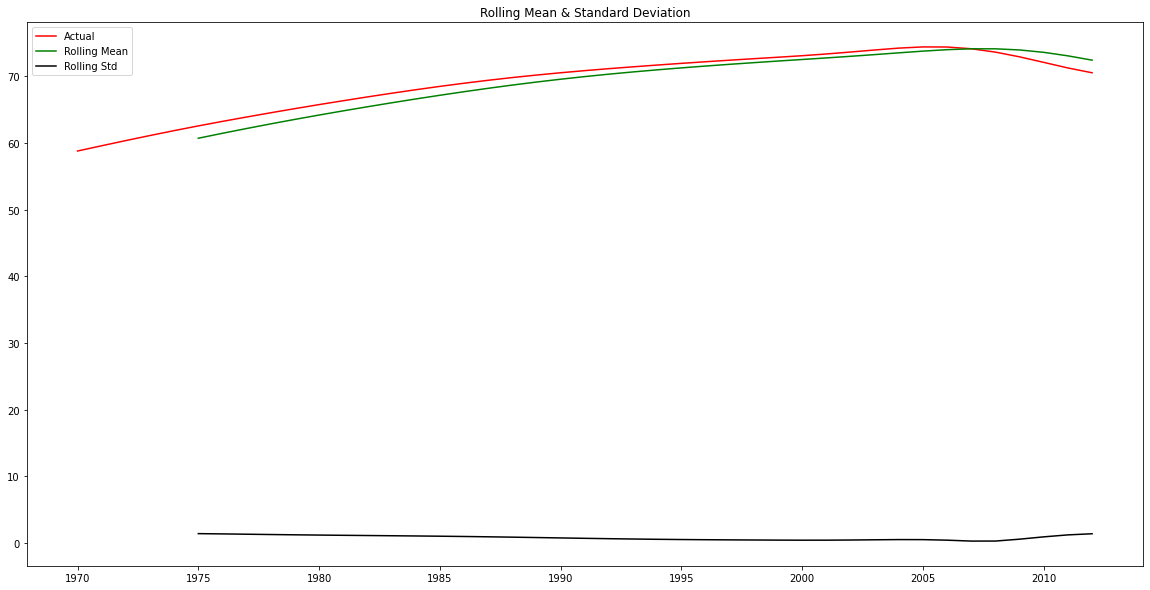

In [572]:
plt.figure(figsize=(20,10))
actual=plt.plot(train_df, color='red', label='Actual')
mean_6=plt.plot(rolmean, color='green', label='Rolling Mean') 
std_6=plt.plot(rolstd, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [573]:
from statsmodels.tsa.stattools import adfuller
print('Dickey-Fuller Test: ')
dftest=adfuller(train_df['Value'], autolag='AIC')
dfoutput=pd.Series(dftest[0:4], index=['Test Statistic','p-value','Lags Used','No. of Obs'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Dickey-Fuller Test: 
Test Statistic          -1.329262
p-value                  0.615681
Lags Used               10.000000
No. of Obs              32.000000
Critical Value (1%)     -3.653520
Critical Value (5%)     -2.957219
Critical Value (10%)    -2.617588
dtype: float64


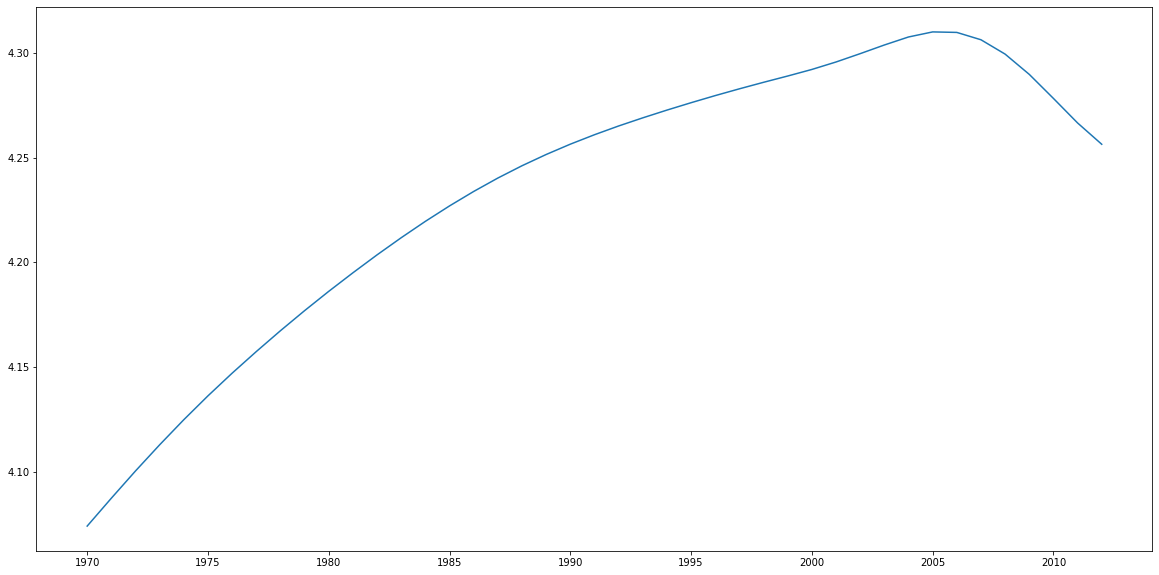

In [574]:
plt.figure(figsize=(20,10))
df_log=np.log(train_df)
plt.plot(df_log)

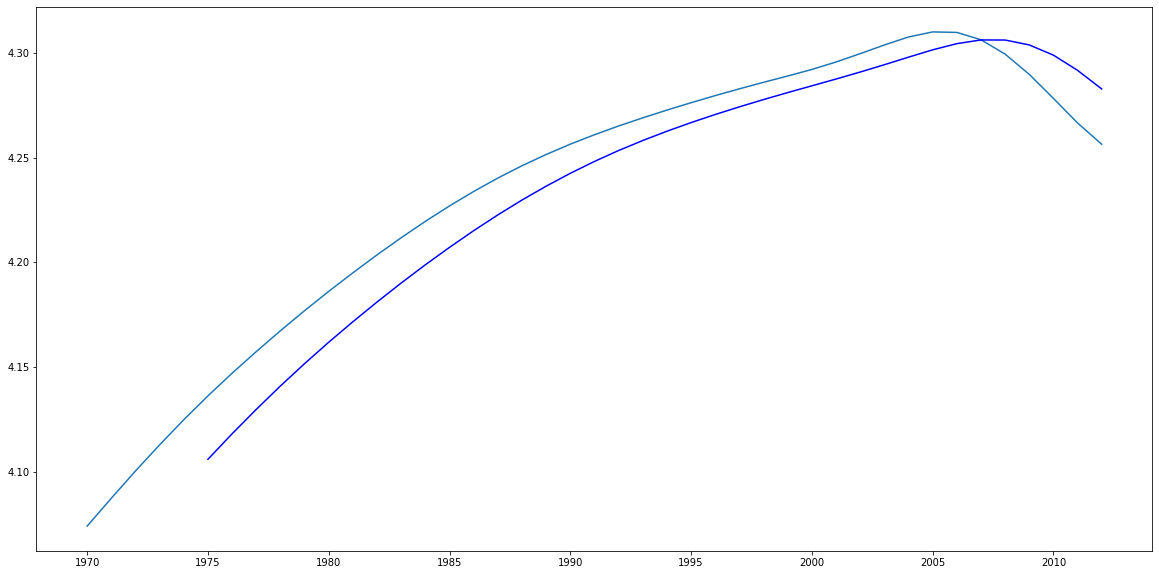

In [575]:
plt.figure(figsize=(20,10))
MAvg=df_log.rolling(window=6).mean()
MStd=df_log.rolling(window=6).std()
plt.plot(df_log)
plt.plot(MAvg, color='blue')

In [576]:
df_log_diff=df_log-MAvg
df_log_diff.head(12)

,Value
Year,
1970-01-01,NaN
1971-01-01,NaN
1972-01-01,NaN
1973-01-01,NaN
1974-01-01,NaN
1975-01-01,0.030217
1976-01-01,0.028869
1977-01-01,0.027539
1978-01-01,0.026330


In [577]:
df_log_diff=df_log_diff.dropna()
df_log_diff.head()

,Value
Year,
1975-01-01,0.030217
1976-01-01,0.028869
1977-01-01,0.027539
1978-01-01,0.026330
1979-01-01,0.025237


In [578]:
def stationarity(timeseries):
    
    rolmean=timeseries.rolling(window=6).mean()
    rolstd=timeseries.rolling(window=6).std()
    
    plt.figure(figsize=(20,10))
    actual=plt.plot(timeseries, color='red', label='Actual')
    mean_6=plt.plot(rolmean, color='green', label='Rolling Mean') 
    std_6=plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    print('Dickey-Fuller Test: ')
    dftest=adfuller(timeseries['Value'], autolag='AIC')
    dfoutput=pd.Series(dftest[0:4], index=['Test Statistic','p-value','Lags Used','No. of Obs'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

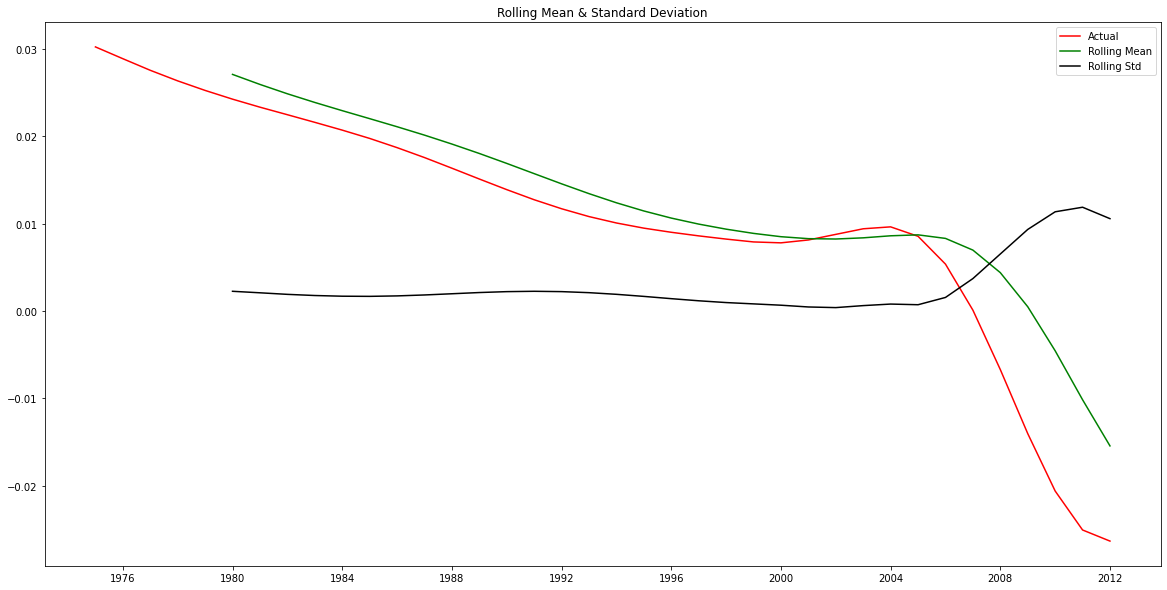

Dickey-Fuller Test: 
Test Statistic          -2.244938
p-value                  0.190342
Lags Used                8.000000
No. of Obs              29.000000
Critical Value (1%)     -3.679060
Critical Value (5%)     -2.967882
Critical Value (10%)    -2.623158
dtype: float64


In [579]:
stationarity(df_log_diff)

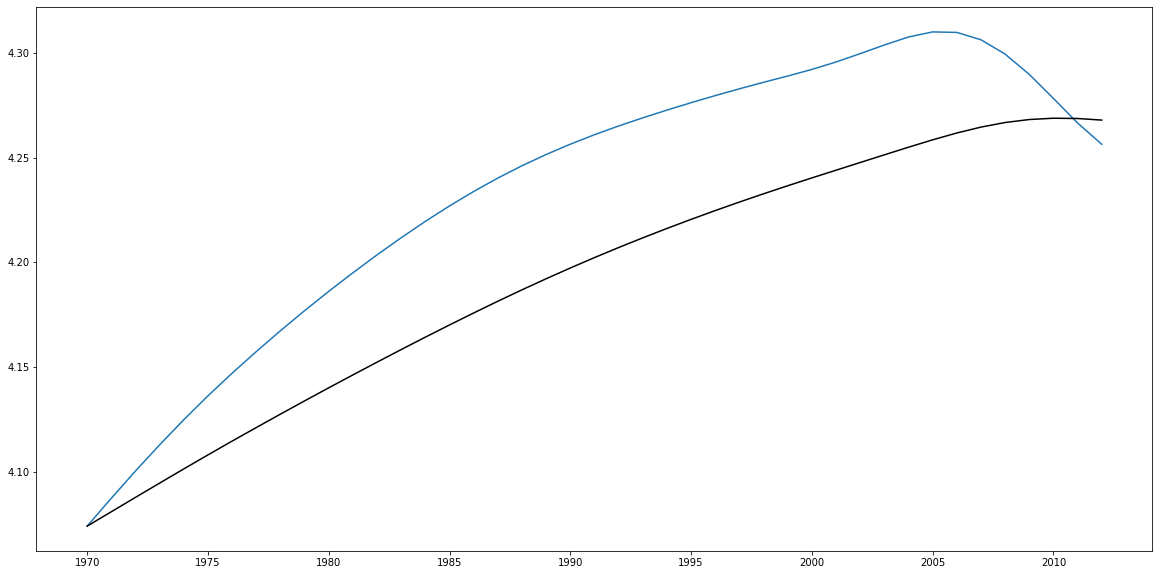

In [580]:
plt.figure(figsize=(20,10))
exp_df=df_log.ewm(halflife=12, min_periods=0, adjust=True).mean()
plt.plot(df_log)
plt.plot(exp_df, color='black')

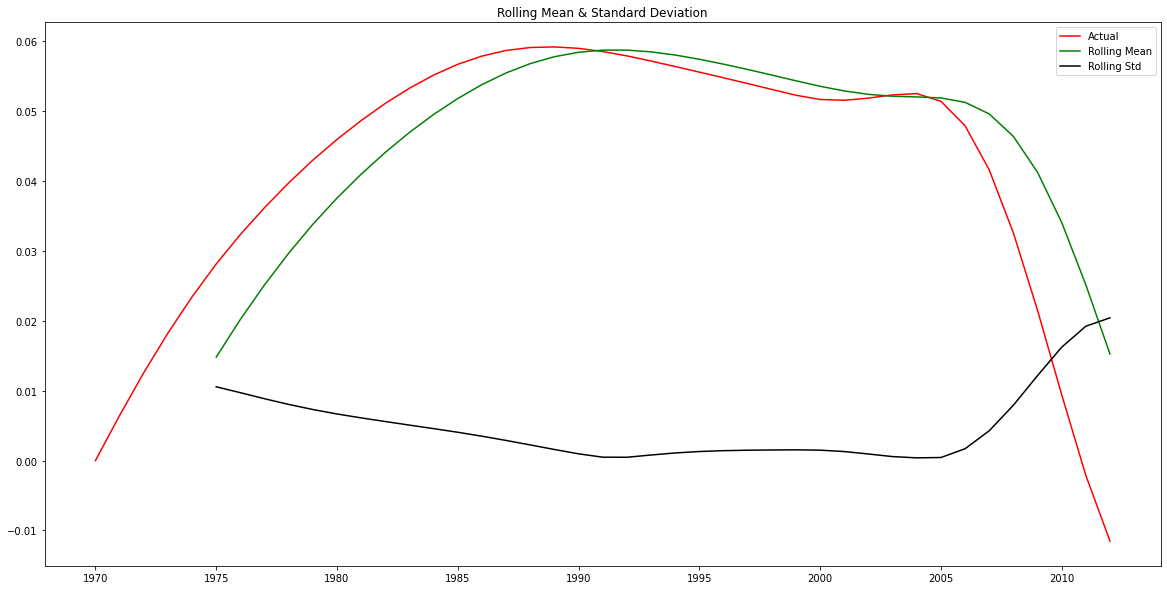

Dickey-Fuller Test: 
Test Statistic          -0.825048
p-value                  0.811653
Lags Used               10.000000
No. of Obs              32.000000
Critical Value (1%)     -3.653520
Critical Value (5%)     -2.957219
Critical Value (10%)    -2.617588
dtype: float64


In [581]:
exp_df_diff=df_log-exp_df
stationarity(exp_df_diff)

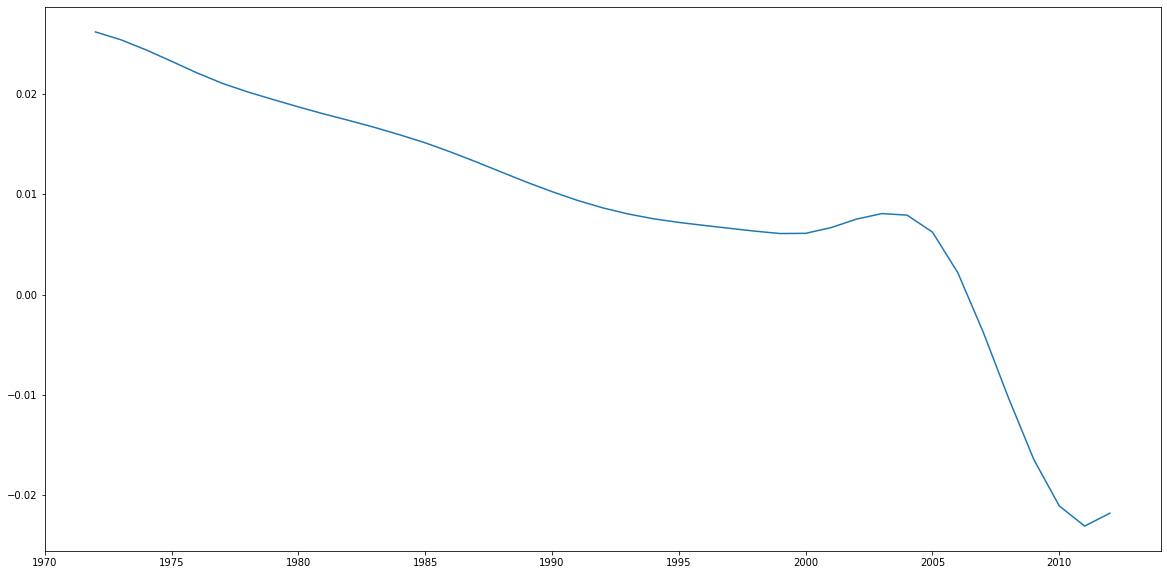

In [582]:
plt.figure(figsize=(20,10))
df_shift=df_log-df_log.shift(2)
plt.plot(df_shift)

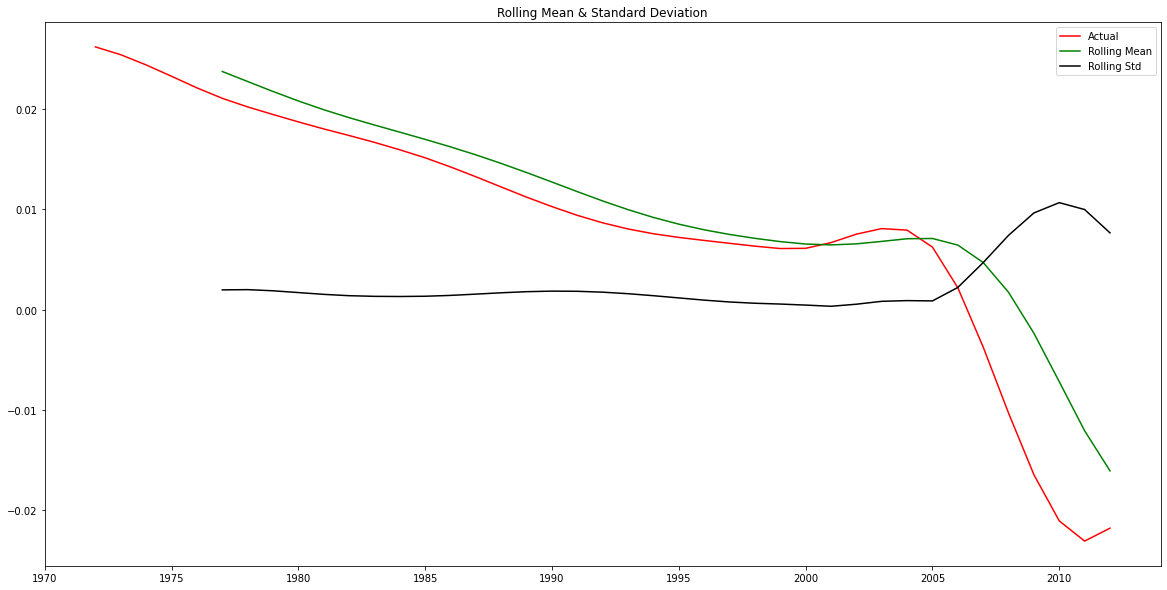

Dickey-Fuller Test: 
Test Statistic          -1.607866
p-value                  0.479641
Lags Used                8.000000
No. of Obs              32.000000
Critical Value (1%)     -3.653520
Critical Value (5%)     -2.957219
Critical Value (10%)    -2.617588
dtype: float64


In [583]:
df_shift=df_shift.dropna()
stationarity(df_shift)

Text(0.5, 1.0, 'Partial Autocorrelation Function')

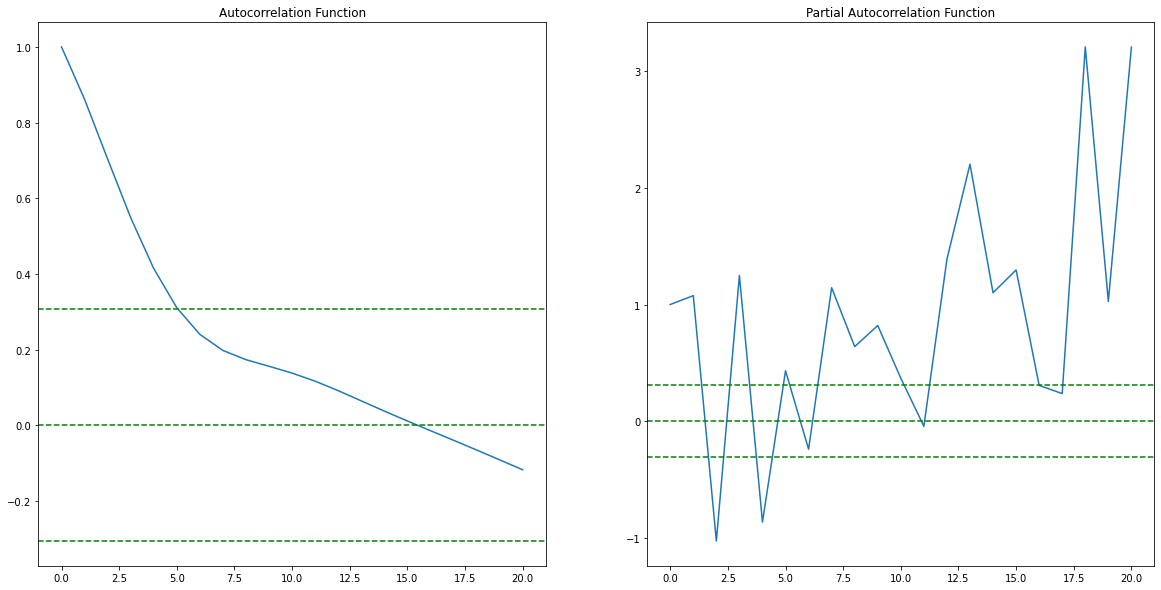

In [592]:
from statsmodels.tsa.stattools import acf, pacf

lag_acf=acf(df_log_diff, nlags=20)
lag_pacf=pacf(df_log_diff, nlags=20, method='ols')

plt.figure(figsize=(20,10))
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='green')
plt.axhline(y=-1.96/np.sqrt(len(df_shift)),linestyle='--',color='green')
plt.axhline(y=1.96/np.sqrt(len(df_shift)),linestyle='--',color='green')
plt.title('Autocorrelation Function')

plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='green')
plt.axhline(y=-1.96/np.sqrt(len(df_shift)),linestyle='--',color='green')
plt.axhline(y=1.96/np.sqrt(len(df_shift)),linestyle='--',color='green')
plt.title('Partial Autocorrelation Function')

plotting ARIMA model


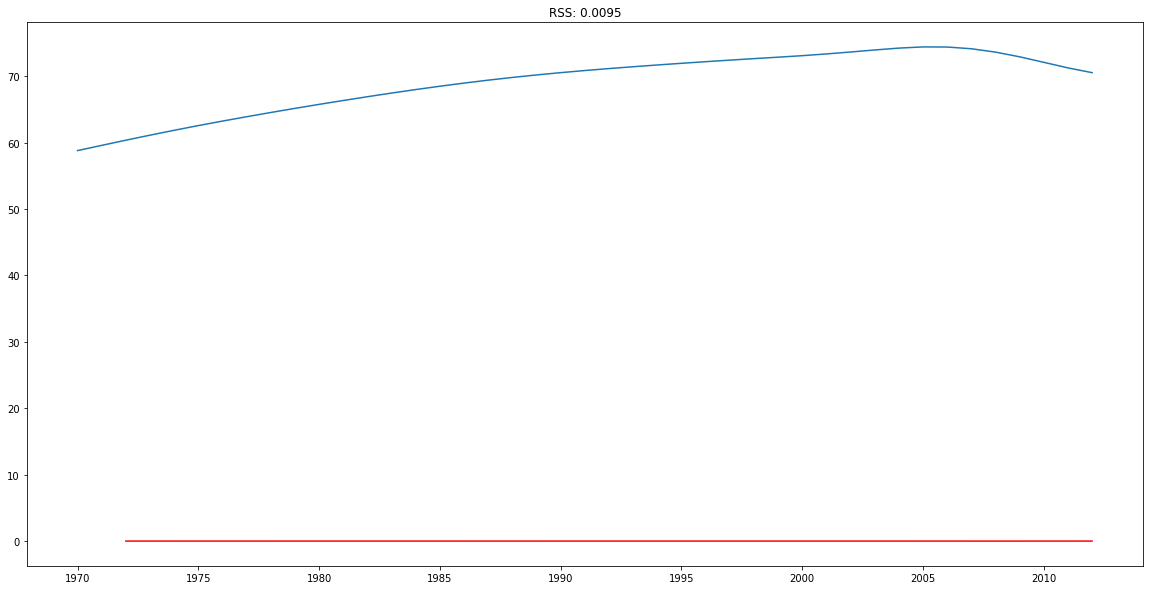

In [619]:
from statsmodels.tsa.arima_model import ARIMA

plt.figure(figsize=(20,10))
model=ARIMA(df_log, order=(1,2,2))
results=model.fit(disp=-1)
plt.plot(train_df)
plt.plot(results.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results.fittedvalues-df_shift['Value'])**2))
print('plotting ARIMA model')

In [620]:
predictions=pd.Series(results.fittedvalues, copy=True)
print(predictions.head())

Year
1972-01-01   -0.000026
1973-01-01   -0.000293
1974-01-01   -0.000553
1975-01-01   -0.000497
1976-01-01   -0.000625
Freq: AS-JAN, dtype: float64


In [621]:
predictions_cum_sum=predictions.cumsum()
print(predictions_cum_sum.head())

Year
1972-01-01   -0.000026
1973-01-01   -0.000318
1974-01-01   -0.000872
1975-01-01   -0.001368
1976-01-01   -0.001993
Freq: AS-JAN, dtype: float64


In [622]:
predictions_log=pd.Series(df_log['Value'].iloc[0], index=df_log.index)
predictions_log=predictions_log.add(predictions_cum_sum,fill_value=0)
#predictions_log.head()

In [623]:
arima_pred = results.predict(start = len(train_df), end = len(df)-1, typ="levels").rename("ARIMA Predictions")
arima_pred=np.exp(arima_pred)
test_df['ARIMA_Predictions'] = arima_pred
#arima_pred


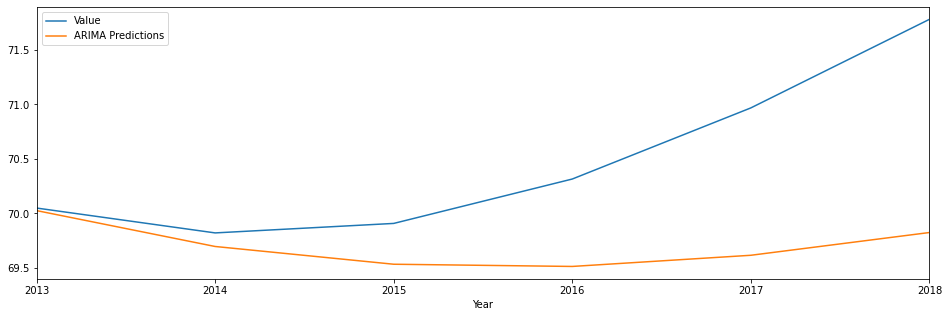

In [624]:
test_df['Value'].plot(figsize = (16,5), legend=True)
arima_pred.plot(legend = True);

In [625]:
arima_rmse_error = rmse(test_df['Value'], arima_pred)
arima_mse_error = arima_rmse_error**2
mean_value = df['Value'].mean()

print(f'MSE Error: {arima_mse_error}\nRMSE Error: {arima_rmse_error}\nMean: {mean_value}')

MSE Error: 1.0739943097401838
RMSE Error: 1.0363369672747296
Mean: 69.29326530612245


In [626]:
output=results.forecast(13)
output1=np.exp(output[0])
output1
outputs = pd.DataFrame(output1[-7:])
outputs.index=['2019', '2020', '2021','2022', '2023', '2024',"2025"]
outputs["Country"]=country_to_predict
outputs

,0,Country
2019,70.125428,Syria
2020,70.507100,Syria
2021,70.959656,Syria
2022,71.474736,Syria
2023,72.045211,Syria
2024,72.664991,Syria
2025,73.328854,Syria


In [627]:
import pandas
from openpyxl import load_workbook

book = load_workbook('test_arima.xlsx')
writer = pandas.ExcelWriter('test_arima.xlsx', engine='openpyxl')
writer.book = book
writer.sheets = {ws.title: ws for ws in book.worksheets}

for sheetname in writer.sheets:
    outputs.to_excel(writer,sheet_name=sheetname, startrow=writer.sheets[sheetname].max_row, index = True,header= False)

writer.save()

In [628]:
test_df

,Value,ARIMA_Predictions
Year,,
2013-01-01,70.049,70.025580
2014-01-01,69.821,69.696529
2015-01-01,69.908,69.533805
2016-01-01,70.315,69.513527
2017-01-01,70.967,69.615916
2018-01-01,71.779,69.824488


**LSTM**

In [659]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [660]:
df=pd.read_excel('test_lstm.xlsx')
df['Year']=pd.to_datetime(df.Year, format="%Y")
df=df[(df['Country']==country_to_predict)]
del df["Country"]
df['Year']=pd.to_datetime(df['Year'], format="%Y")
df=df.set_index(['Year'])
df.index.freq = 'YS'
train_df_lstm = df[:len(df)-6]
test_df_lstm = df[len(df)-6:]
df.tail()

,Value
Year,
2014-01-01,69.821
2015-01-01,69.908
2016-01-01,70.315
2017-01-01,70.967
2018-01-01,71.779


In [661]:
scaler.fit(train_df)
scaled_train_data = scaler.transform(train_df_lstm)
scaled_test_data = scaler.transform(test_df_lstm)

In [662]:
from keras.preprocessing.sequence import TimeseriesGenerator

n_input = 1
n_features= 1
generator = TimeseriesGenerator(scaled_train_data, scaled_train_data, length=n_input, batch_size=1)

In [663]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

lstm_model = Sequential()
lstm_model.add(LSTM(64, activation='relu', input_shape=(n_input, n_features)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

lstm_model.summary()

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_25 (LSTM)               (None, 64)                16896     
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 65        
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________


In [664]:
lstm_model.fit_generator(generator,epochs=20)

Epoch 1/20
42/42 [==============================] - 0s 2ms/step - loss: 0.4736
Epoch 2/20
42/42 [==============================] - 0s 2ms/step - loss: 0.3367
Epoch 3/20
42/42 [==============================] - 0s 2ms/step - loss: 0.2102
Epoch 4/20
42/42 [==============================] - 0s 2ms/step - loss: 0.0984
Epoch 5/20
42/42 [==============================] - 0s 2ms/step - loss: 0.0374
Epoch 6/20
42/42 [==============================] - 0s 2ms/step - loss: 0.0198
Epoch 7/20
42/42 [==============================] - 0s 2ms/step - loss: 0.0167
Epoch 8/20
42/42 [==============================] - 0s 2ms/step - loss: 0.0158
Epoch 9/20
42/42 [==============================] - 0s 2ms/step - loss: 0.0146
Epoch 10/20
42/42 [==============================] - 0s 2ms/step - loss: 0.0135
Epoch 11/20
42/42 [==============================] - 0s 2ms/step - loss: 0.0125
Epoch 12/20
42/42 [==============================] - 0s 2ms/step - loss: 0.0115
Epoch 13/20
42/42 [==============================

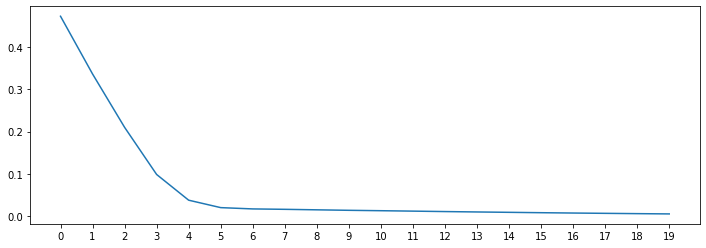

In [665]:
losses_lstm = lstm_model.history.history['loss']
plt.figure(figsize=(12,4))
plt.xticks(np.arange(0,21,1))
plt.plot(range(len(losses_lstm)),losses_lstm);

In [666]:
lstm_predictions_scaled = list()

batch = scaled_train_data[-n_input:]
current_batch = batch.reshape((1, n_input, n_features))

for i in range(len(test_df)):   
    lstm_pred = lstm_model.predict(current_batch)[0]
    lstm_predictions_scaled.append(lstm_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis=1)

In [667]:
lstm_predictions_scaled

[array([0.7519942], dtype=float32),
 array([0.75235933], dtype=float32),
 array([0.7526508], dtype=float32),
 array([0.7528837], dtype=float32),
 array([0.7530697], dtype=float32),
 array([0.7532183], dtype=float32)]

In [668]:
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)

In [669]:
lstm_predictions

array([[70.55714131],
       [70.56284331],
       [70.56739485],
       [70.57103143],
       [70.57393642],
       [70.57625687]])

In [670]:
test_df['LSTM_Predictions'] = lstm_predictions

In [671]:
test_df

,Value,ARIMA_Predictions,LSTM_Predictions
Year,,,
2013-01-01,70.049,70.025580,70.557141
2014-01-01,69.821,69.696529,70.562843
2015-01-01,69.908,69.533805,70.567395
2016-01-01,70.315,69.513527,70.571031
2017-01-01,70.967,69.615916,70.573936
2018-01-01,71.779,69.824488,70.576257


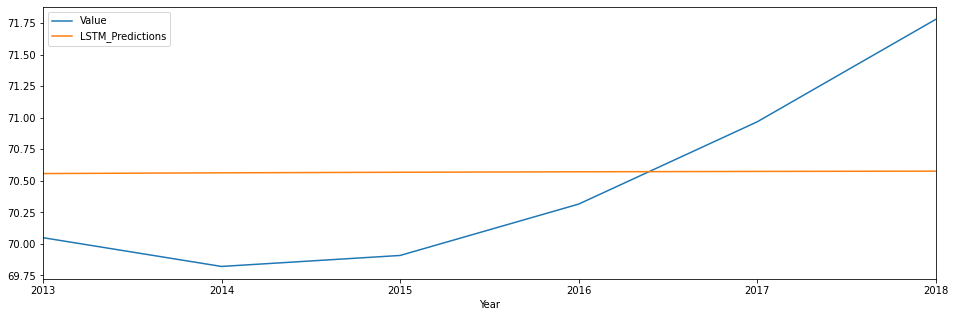

In [672]:
test_df['Value'].plot(figsize = (16,5), legend=True)
test_df['LSTM_Predictions'].plot(legend = True);

In [673]:
lstm_rmse_error = rmse(test_df['Value'], test_df["LSTM_Predictions"])
lstm_mse_error = lstm_rmse_error**2
mean_value = df['Value'].mean()

print(f'MSE Error: {lstm_mse_error}\nRMSE Error: {lstm_rmse_error}\nMean: {mean_value}')

MSE Error: 0.48499712941775375
RMSE Error: 0.6964173528982127
Mean: 69.29326530612245


In [674]:
lstm_predictions_scaled = list()

batch = scaled_train_data[-n_input:]
current_batch = batch.reshape((1, n_input, n_features))

for i in range(len(test_df)+6):   
    lstm_pred = lstm_model.predict(current_batch)[0]
    lstm_predictions_scaled.append(lstm_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis=1)

In [675]:
lstm_predictions_scaled

[array([0.7519942], dtype=float32),
 array([0.75235933], dtype=float32),
 array([0.7526508], dtype=float32),
 array([0.7528837], dtype=float32),
 array([0.7530697], dtype=float32),
 array([0.7532183], dtype=float32),
 array([0.753337], dtype=float32),
 array([0.7534318], dtype=float32),
 array([0.7535076], dtype=float32),
 array([0.7535682], dtype=float32),
 array([0.75361663], dtype=float32),
 array([0.75365525], dtype=float32)]

In [676]:
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)

In [677]:
lstm_predictions

array([[70.55714131],
       [70.56284331],
       [70.56739485],
       [70.57103143],
       [70.57393642],
       [70.57625687],
       [70.57811099],
       [70.57959094],
       [70.5807749 ],
       [70.58172058],
       [70.58247731],
       [70.58308046]])

In [678]:
output2=lstm_predictions
outputs2 = pd.DataFrame(lstm_predictions[-7:])
outputs2.index=['2019', '2020', '2021','2022', '2023', '2024',"2025"]
outputs2["Country"]=country_to_predict
outputs2

,0,Country
2019,70.576257,Syria
2020,70.578111,Syria
2021,70.579591,Syria
2022,70.580775,Syria
2023,70.581721,Syria
2024,70.582477,Syria
2025,70.583080,Syria


In [679]:
import pandas
from openpyxl import load_workbook

book = load_workbook('test_lstm.xlsx')
writer = pandas.ExcelWriter('test_lstm.xlsx', engine='openpyxl')
writer.book = book
writer.sheets = {ws.title: ws for ws in book.worksheets}

for sheetname in writer.sheets:
    outputs2.to_excel(writer,sheet_name=sheetname, startrow=writer.sheets[sheetname].max_row, index = True,header= False)

writer.save()

**Prophet**

In [680]:
df = pd.read_excel('test_prophet.xlsx')
df=df[(df['Country']==country_to_predict)]
del df["Country"]
df.head()
df_pr = df.copy()
#df = df.reset_index()
df_pr.columns = ['ds','y']
df_pr.tail()


,ds,y
387,2014,69.821
388,2015,69.908
389,2016,70.315
390,2017,70.967
391,2018,71.779


In [681]:
df_pr['ds'] = pd.to_datetime(df_pr['ds'],format="%Y")
df_pr.tail()

,ds,y
387,2014-01-01,69.821
388,2015-01-01,69.908
389,2016-01-01,70.315
390,2017-01-01,70.967
391,2018-01-01,71.779


In [682]:
train_data_pr = df_pr.iloc[:len(df)-6]
test_data_pr = df_pr.iloc[len(df)-6:]

In [683]:
from fbprophet import Prophet

In [684]:
m = Prophet()
m.fit(train_data_pr)
future = m.make_future_dataframe(periods=6,freq='YS')
prophet_pred = m.predict(future)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [685]:
prophet_pred.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
44,2014-01-01,16.836465,70.544934,71.462770,16.768876,16.905070,54.145308,54.145308,54.145308,54.145308,54.145308,54.145308,0.0,0.0,0.0,70.981773
45,2015-01-01,16.520314,70.155116,71.116547,16.385468,16.664705,54.107846,54.107846,54.107846,54.107846,54.107846,54.107846,0.0,0.0,0.0,70.628160
46,2016-01-01,16.204162,69.774650,70.816724,15.984411,16.440028,54.103288,54.103288,54.103288,54.103288,54.103288,54.103288,0.0,0.0,0.0,70.307451
47,2017-01-01,15.887145,69.560945,70.670703,15.572186,16.226642,54.215388,54.215388,54.215388,54.215388,54.215388,54.215388,0.0,0.0,0.0,70.102533
48,2018-01-01,15.570994,69.061372,70.387891,15.161470,16.030376,54.145308,54.145308,54.145308,54.145308,54.145308,54.145308,0.0,0.0,0.0,69.716303


In [686]:
prophet_pred = pd.DataFrame({"Year" : prophet_pred[-6:]['ds'], "Pred" : prophet_pred[-6:]["yhat"]})

In [687]:
prophet_pred = prophet_pred.set_index("Year")

In [688]:
prophet_pred.index.freq = "YS"

In [689]:
prophet_pred

,Pred
Year,
2013-01-01,71.368004
2014-01-01,70.981773
2015-01-01,70.628160
2016-01-01,70.307451
2017-01-01,70.102533
2018-01-01,69.716303


In [690]:
test_df["Prophet_Predictions"] = prophet_pred['Pred'].values
test_df

,Value,ARIMA_Predictions,LSTM_Predictions,Prophet_Predictions
Year,,,,
2013-01-01,70.049,70.025580,70.557141,71.368004
2014-01-01,69.821,69.696529,70.562843,70.981773
2015-01-01,69.908,69.533805,70.567395,70.628160
2016-01-01,70.315,69.513527,70.571031,70.307451
2017-01-01,70.967,69.615916,70.573936,70.102533
2018-01-01,71.779,69.824488,70.576257,69.716303


In [691]:
import seaborn as sns

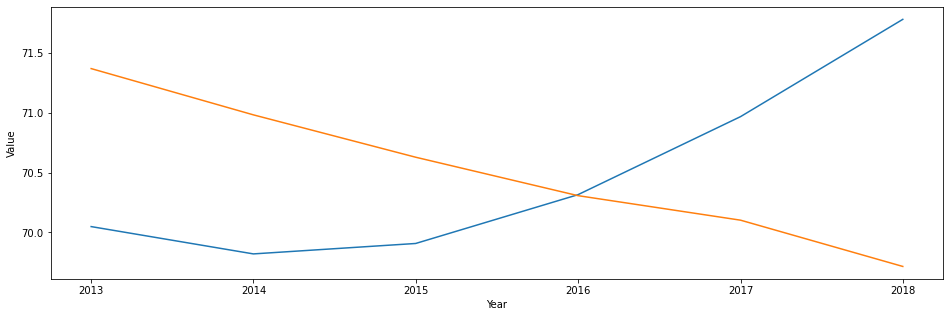

In [692]:
plt.figure(figsize=(16,5))
ax = sns.lineplot(x= test_df.index, y=test_df["Value"])
sns.lineplot(x=test_df.index, y = test_df["Prophet_Predictions"]);

In [693]:
prophet_rmse_error = rmse(test_df['Value'], test_df["Prophet_Predictions"])
prophet_mse_error = prophet_rmse_error**2
mean_value = df['Value'].mean()

print(f'MSE Error: {prophet_mse_error}\nRMSE Error: {prophet_rmse_error}\nMean: {mean_value}')

MSE Error: 1.4346460891408133
RMSE Error: 1.197767126423502
Mean: 69.29326530612245


In [694]:
future = m.make_future_dataframe(periods=13,freq = 'YS')
prophet_pred = m.predict(future)

In [695]:
#prophet_pred = pd.DataFrame({"Year" : prophet_pred[-11:]['ds'], "Pred" : prophet_pred[-11:]["yhat"]})
abc=prophet_pred[['ds', 'yhat']].tail(7)

In [696]:
abc.index=['2019', '2020', '2021','2022', '2023', '2024',"2025"]
del abc['ds']
abc = abc.rename(columns={'yhat': 'Value'})
abc["Country"]=country_to_predict
abc

,Value,Country
2019,69.362689,Syria
2020,69.041980,Syria
2021,68.837062,Syria
2022,68.450832,Syria
2023,68.097218,Syria
2024,67.776509,Syria
2025,67.571592,Syria


In [697]:
import pandas
from openpyxl import load_workbook

book = load_workbook('test_prophet.xlsx')
writer = pandas.ExcelWriter('test_prophet.xlsx', engine='openpyxl')
writer.book = book
writer.sheets = {ws.title: ws for ws in book.worksheets}

for sheetname in writer.sheets:
    abc.to_excel(writer,sheet_name=sheetname, startrow=writer.sheets[sheetname].max_row, index = True,header= False)

writer.save()

In [698]:
rmse_errors = [arima_rmse_error, lstm_rmse_error, prophet_rmse_error]
mse_errors = [arima_mse_error, lstm_mse_error, prophet_mse_error]
errors = pd.DataFrame({"Models" : ["ARIMA", "LSTM", "Prophet"],"RMSE Errors" : rmse_errors, "MSE Errors" : mse_errors})

Mean: 70.47316666666667


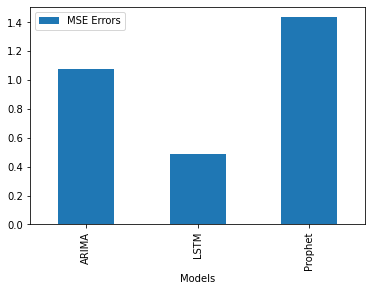

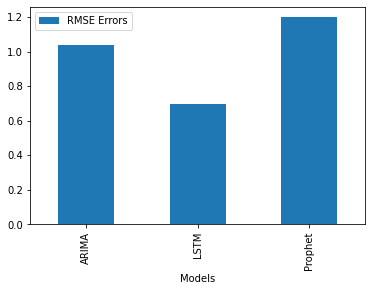

In [699]:
print(f"Mean: {test_df['Value'].mean()}")
errors
errors.plot(kind="bar",x="Models",y="MSE Errors")
errors.plot(kind="bar",x="Models",y="RMSE Errors")

In [700]:
errors["Country"]=country_to_predict
errors

,Models,RMSE Errors,MSE Errors,Country
0,ARIMA,1.036337,1.073994,Syria
1,LSTM,0.696417,0.484997,Syria
2,Prophet,1.197767,1.434646,Syria


In [701]:
import pandas
from openpyxl import load_workbook

book = load_workbook('errors.xlsx')
writer = pandas.ExcelWriter('errors.xlsx', engine='openpyxl')
writer.book = book
writer.sheets = {ws.title: ws for ws in book.worksheets}

for sheetname in writer.sheets:
    errors.to_excel(writer,sheet_name=sheetname, startrow=writer.sheets[sheetname].max_row, index =False,header= False)

writer.save()

In [702]:
output3=test_df
output3["Country"]=country_to_predict
output3.reset_index()
output3.index=['2013', '2014', '2015','2016', '2017', '2018']
output3

,Value,ARIMA_Predictions,LSTM_Predictions,Prophet_Predictions,Country
2013,70.049,70.025580,70.557141,71.368004,Syria
2014,69.821,69.696529,70.562843,70.981773,Syria
2015,69.908,69.533805,70.567395,70.628160,Syria
2016,70.315,69.513527,70.571031,70.307451,Syria
2017,70.967,69.615916,70.573936,70.102533,Syria
2018,71.779,69.824488,70.576257,69.716303,Syria


In [703]:
import pandas
from openpyxl import load_workbook

book = load_workbook('comparison.xlsx')
writer = pandas.ExcelWriter('comparison.xlsx', engine='openpyxl')
writer.book = book
writer.sheets = {ws.title: ws for ws in book.worksheets}

for sheetname in writer.sheets:
    output3.to_excel(writer,sheet_name=sheetname, startrow=writer.sheets[sheetname].max_row, index =True,header= False)

writer.save()

<Figure size 1368x648 with 0 Axes>

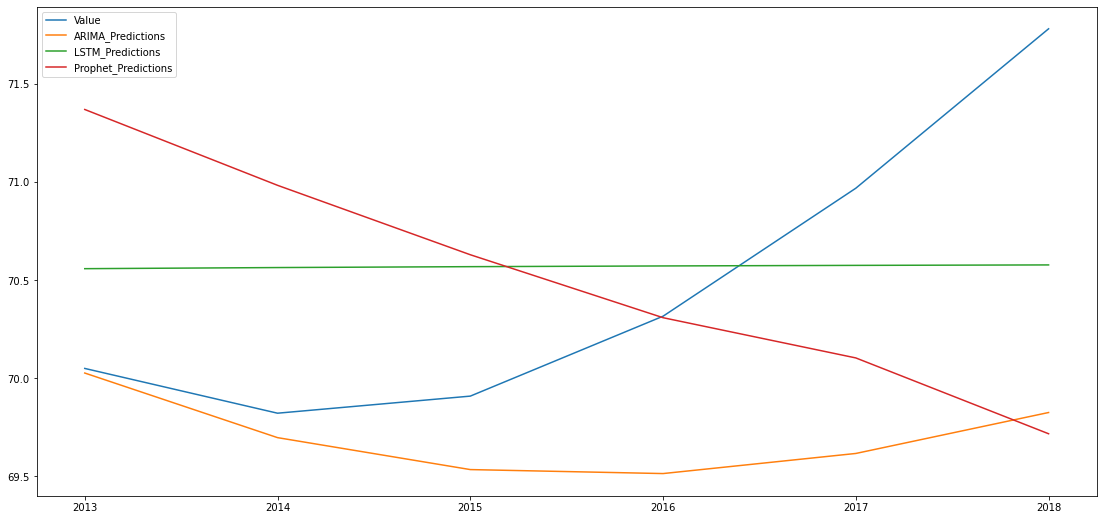

In [704]:
plt.figure(figsize=(19,9))
test_df.plot(figsize=(19,9))